# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys

from itertools import product
from os.path import isdir, isfile
from random import shuffle


import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.model_selection import  cross_validate, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as KNN

import torch
import torch.nn as nn

# Set up datapath
base_path = './datasets/petsounds/cats_dogs/'

if not isdir(base_path):
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

# Lambda to construct full path to cat/dog files
route = lambda x: base_path + x    
    
# Get dictionary of sounds
cat_file = 'cat_{}.wav'
dog_file = 'dog_barking_{}.wav'

pet_sounds = {'cat': [], 'dog': []}
for i in range(0, 168):
    this_cat = cat_file.format(i)
    
    if isfile(route(this_cat)):
        pet_sounds['cat'].append(this_cat)
        
    this_dog = dog_file.format(i)
    if isfile(route(this_dog)):
        pet_sounds['dog'].append(this_dog)

# 1.) Pre-process a single file using 20 frequency bins, and 2000 Hz sampling frequency.

Spectograph


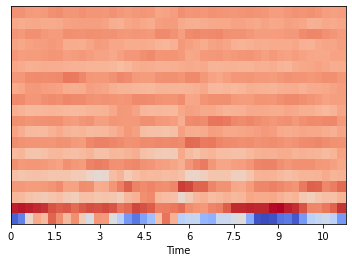

Waveform


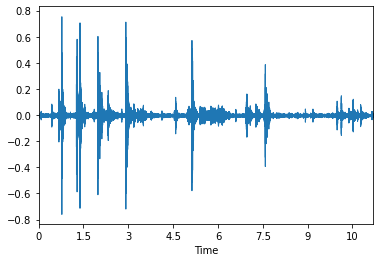

In [14]:
SAMPLING_FRQ = 2000
BINS = 20

# Process the first cat file
x, fs = librosa.load(base_path + pet_sounds['cat'][0], sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
print("Spectograph")
plt.show()
librosa.display.waveplot(y=x, sr=fs)
print("Waveform")
plt.show()

# 2.) Process each into X and Y matrices. Apply a classifier and comment on results.

### Some setup

In [6]:
# Up sampling frequency to 4k
SAMPLING_FRQ = 4000

# Set the FFT length; this leads to better sklearn accuracy and 
#     prevents warnings about frame size.
# https://librosa.org/doc/main/ioformats.html?highlight=n_fft
# https://librosa.org/doc/main/glossary.html?highlight=n_fft
FFT = (2048 * SAMPLING_FRQ) // 22050

# Generator function to get all dogs/cats files and label
def get_pet(ps_dict=pet_sounds):
    for pet in ['cat', 'dog']:
        for i in range(0, len(ps_dict[pet])):
            yield(ps_dict[pet][i], pet)
        
    return None

# Function to format a scores array into a string for clean output
def score_string(scores):
    score_str = ''
    for idx, score in enumerate(scores):
        score_str += f'{score:.3f}'

        if idx < len(scores)-1:
            score_str += ', '
    return score_str

### Convert each file into a waveform and store to MFCC

In [7]:
%%time

ps_mfcc = []

for file, pet in get_pet():
    wf, sr = librosa.load(route(file), sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(wf, sr=sr, n_mfcc=BINS)
    
    mfccs = mfccs.T
    
    ps_mfcc += [(mfccs, pet)]

Wall time: 23.5 s


### Do some sklearn

Parameters for SVC were found through GridSearchCV, but it took 2 hours and I was mad the results favoured SVC so I deleted it. Luckily, this cell doesn't take too long (about 30 seconds).

For reference, I also tried RandomForestClassifier and K-Nearest Neighbors, both of which performed similarly but worse.

Stratified K-Fold vs regualar K-Fold seems to not change the outcomes very much here (expected due to class balance). 
Shuffling the K-Fold improves the scores by about 5% in either K-Fold variety.

In [8]:
# Split the data into X and Y
# I adapated this from the office hours recording after
# running into a problem with datatypes for the RNN
N = sum([ps.shape[0] for (ps, pet) in ps_mfcc])

X = np.zeros((N, BINS))
Y = []

idx = 0
for mfcc, pet in ps_mfcc:
    n = mfcc.shape[0]
    for jdx in range(n):
        X[idx+jdx, :] = mfcc[jdx]
        
    idx += n
    
    Y += [0 if pet == 'cat' else 1]*n
    
Y = np.array(Y)

In [9]:
%%time

# Run cross-validation
model = SVC(C=10, kernel='poly') 
kfold = StratifiedKFold(n_splits=10, shuffle=True) 

sk_scores = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')

# Display scores and statistics
print(f'Model: {model}')
print(f'\tScores: {score_string(sk_scores)}')
print(f'\tMean: {np.mean(sk_scores):.4f}')
print(f'\tSTD: {np.std(sk_scores):.4f}\n')

Model: SVC(C=10, kernel='poly')
	Scores: 0.906, 0.914, 0.912, 0.904, 0.915, 0.905, 0.914, 0.904, 0.913, 0.904
	Mean: 0.9089
	STD: 0.0047

Wall time: 38.4 s


### Discussion

I'm very satisfied with a mean score of ~0.9. I'm also surprised that shuffling the data around in the KFold produced better results, as the datapoints here are interrelated.

# 3.) Use an RNN to classify and compare results with the model above.

### Reorganize data

Adapted from office hours.

In [10]:
n_signals = len(ps_mfcc)
ps_mfcc2 = [None]*n_signals

for i in range(n_signals):
    ps_mfcc2[i] = (torch.tensor(ps_mfcc[i][0], dtype=torch.float),
                   torch.tensor([0 if ps_mfcc[i][1] == 'cat' else 1], dtype=torch.long))

### Model definition

Adapted from module notebook and office hours.

In [11]:
class RNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, eta=0.00075):
        super(RNN, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_features + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_features + n_hidden, n_output)
        self.softmax = nn.LogSoftmax(dim=1)

        self.eta = eta  # learning rate
        
        self.epochs = 50
        self.batch_size = 1000
        
        # loss function, since the last layer is nn.LogSoftmax
        self.criterion = nn.NLLLoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.eta)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.n_hidden)
    
    def predict(self, sxx):
        y_pred = []
        with torch.no_grad():
            hidden = self.init_hidden()
            
            for i in range(sxx.shape[0]):
                output, hidden = self.forward(sxx[i].reshape(1,self.n_features), hidden)
                y_pred.append(0 if output[0][0]>output[0][1] else 1)
            
        return y_pred

    def train(self, mfccs, epoch=None, cv=None):
           
        tot_loss = 0
       
        # For each signal
        for idx, (sxx, y) in enumerate(mfccs):
            self.optimizer.zero_grad()
            hidden = self.init_hidden()
            
            # Train the whole signal
            for jdx in range(sxx.shape[0]):
                output, hidden = self.forward(sxx[jdx].reshape(1, self.n_features), hidden)
                
            # Generate and apply loss
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
        
            tot_loss += loss
        
            # Display progress
            msg = f"\rCV: {cv} | Epoch: {epoch} | "
            msg += f"Signal: {idx+1:03d}/{len(mfccs)} | " 
            msg += f"Loss: {loss:6.2f} | Avg. Loss: {tot_loss/(idx+1):6.2f}"
        
            sys.stderr.write(msg)
            sys.stderr.flush()
        
        return output, loss.item()

### Do some RNN

In [12]:
# Function to run a 10-fold CV w/ the RNN
def cv10(n_hidden=15, lr=0.00065, epochs=50):
    
    scores = []

    kfold = KFold(n_splits = 10)
    index = np.arange(len(ps_mfcc2))

    for cv, (train_idx, test_idx) in enumerate(kfold.split(index)):
        rnn = RNN(20, n_hidden, 2, eta=lr)

        training = [ps_mfcc2[i] for i in train_idx]
        testing = [ps_mfcc2[i] for i in test_idx]

        # Train
        for epo in range(epochs):
            shuffle(training)
            rnn.train(training, epo+1, cv+1)

        # Test
        # Get predictions
        y_pred = []
        for mfcc in testing:
            y_pred += rnn.predict(mfcc[0])

        # Get targets
        targets = []
        for idx, y in enumerate(testing):
            targets.append(y[1])

        # Count correct predictions, get accuracy, and store as score
        score = 0
        for pred, tar in zip(y_pred, targets):
            score += 1 if pred == tar else 0

        score = score / len(targets)

        scores.append(score)
        
    return scores

In [13]:
search = False

rnn_scores = []

# Grid search parameters
lrs = [0.00075, 0.0005, 00.00025]
hiddens = [15, 20]

# If search is set, run a grid search
if search:
    max_score = 0
    best_params = (None, None)
    for lr, hidden in product(lrs, hiddens):
        these_scores = cv10(hidden, lr)
        score = np.mean(these_scores)

        if score > max_score:
            max_score = score
            best_params = (lr, hidden)
            rnn_scores = these_scores

    print(f"Best Learning Rate: {best_params[0]} | Best Num. Hidden: {best_params[1]}")
    
# Otherwise run with our default settings.
else:
    rnn_scores = cv10()

# Change topline of results message if appropriate
topline = 'Score statistics for best run:' if search else 'Model: RNN'

print(topline)
print(f'\tScores: {score_string(rnn_scores)}')
print(f'\tMean: {np.mean(rnn_scores):.4f}')
print(f'\tSTD: {np.std(rnn_scores):.4f}\n')

CV: 10 | Epoch: 50 | Signal: 250/250 | Loss:   0.02 | Avg. Loss:   0.21

Model: RNN
	Scores: 0.643, 0.893, 0.571, 0.786, 0.500, 0.679, 0.250, 0.778, 0.852, 0.704
	Mean: 0.6655
	STD: 0.1801



### Comparision to Scikit-learn model.

In general, the RNN here did not perform as well as the SVC in part 2 with some outliers that were on par with SVC (I saw at least one 0.85 score in testing). Some of the results are worse than random too, which is telling of the sophistication of this particular implementation of the RNN architecture. Likely, it is the case that some TLC and parameter tuning would improve the performance of this RNN. We could probably also add additional layers and/or additional layer types (like LSTMs). I also think more signals would also probably be useful. 

The biggest difference to me I guess would be the lack of consistency out of the RNN (which, again, can probably be fixed).

Additionally, it does take way longer to train, but it probably wouldn't be too bad if I was using CUDA (my work machine is an iMac, so I didn't implement that).

# 4. Compare this RNN to the CNN in 60-minute Blitz.

The RNN here and the CNN have similiar methodologies largely thanks to the PyTorch library. Thanks to the library we don't have to define how slide the kernel across the images in the CNN and we don't have to define our optimizer or loss function in either, which from personal experience in undergrad can be a pain (especially when you have to use Matlab; my NN class was very math based). 

A large portion of this assignment (for me) was getting the data wrangled in a usuable fashion for the RNN, but the data for image classifier in the Blitz came preprocessed from PyTorch. The other difference in the data was that the CNN layer from PyTorch can be set to read multiple channels (in the case of the image processing this would be the RGB data), whereas in our RNN we had to run each of the signals through 'manually' before applying the loss. 